# Clustering and Market Regimes
### Part 2 -  Regime-Based Trading Algorithm Backtest
<sub>**by Aung Si**</sub><br>
<sub>June 23<sup>rd</sup>, 2023</sub>

---

## Before We Begin

#### *Organization of Code*
In this analysis, I've employed a modular approach to the code. Most of the code blocks follow the following format:
1. Defining helper functions necessary for the portion of analysis.
2. Utilising these helper functions to execute the specific analysis task or to generate results.

This way, the code is kept organized and replicability is made easy.

#### *Using `clustering.py`*
Some of the functions used in this paper are the same ones used in part I of *Clustering and Market Regimes*, so I've written them into a module, `clustering.py`. For the sake of clarity, I didn't use an alias for this module in the import. `clustering.py` also holds the logic for the backtesting dataframe, wherein I log all entries, exits, and corresponding metrics of the backtest. For brevity, I'll save the explanation for this in a later paper, as the logic can be a bit lengthy and isn't the focus of this project.

#### *Accounting For Transaction Fees and Taxes*
Often one of the main pitfalls of backtesting is the insufficient/absence of accounting for transaction fees and taxes. I've tried my best to make up for this by setting a transaction fee percentage of 0.2%, incurred on each entry and each exit, and a tax rate of 15%, incurred on each profitable trade.

---

## Analysis and Code

In the first segment of our exploration into Clustering and Market Regimes, we deployed four distinct clustering methods - namely, KMeans and Hierarchical (also known as Agglomerative) - to uncover market regimes within the year 2023. Now, we'll venture into a backtest of a trading strategy that leans on the shifts in market regimes and momentum. The purpose of is to underscore the importance of strategic positioning according to regime paradigms. For this analysis, we'll be utilizing the KMeans clustering approach with an assumption of two ($n=2$) clusters.

### 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import clustering

from data_functions import get_pricing
from sklearn.cluster import KMeans

Our training period will encompass a volatile time span from 2006 to 2012, a period that includes both the onset and subsequent subsiding of the 2008 financial crisis. My theory is that, by training our clustering model during a phase of significant market turbulence, it will be equipped to handle the inherent volatility present during our testing period, which is from 2020 to 2023. This latter period encapsulates various dramatic economic events, including the pandemic, high inflation, a series of bank collapses, and multiple interest rate increases. These elements might mirror the tumultuous market conditions experienced between 2006 and 2012.

That said, I could just be plain wrong. Market data is still notoriously turbulent and random, and there are no guarantees. Regardless, it's a start!

In [2]:
# FETCHING STOCK PRICES AND RETURNS DATA.
# ==============================================================================================================

tr_start = '2006-01-01'
tr_end = '2012-01-01'

ts_start = '2020-01-01'
ts_end = '2023-06-23'
ticker = 'SPY'

prices = get_pricing(ticker, start=tr_start, end=tr_end) # Training prices.
ts_prices = get_pricing(ticker, start=ts_start, end=ts_end) # Testing prices.

In [3]:
# FEATURE ENGINEERING.
# ==============================================================================================================

window = 20
std_threshold = 2
autocorr_lag = 2

data = clustering.engineer_features(prices, window, std_threshold, autocorr_lag) # Training dataset.
unseen_data = clustering.engineer_features(ts_prices, window, std_threshold, autocorr_lag) # Testing dataset.

display(data.head(2))
display(unseen_data.head(2))

,prices,returns,volatility,ma,skew,kurt,autocorr,jump
Date,,,,,,,,
2006-02-01,128.39,0.006956,0.006199,0.000663,-1.502198,3.743182,0.090527,0
2006-02-02,126.90,-0.011673,0.006698,-0.000157,-1.159157,1.800946,0.158513,0


,prices,returns,volatility,ma,skew,kurt,autocorr,jump
Date,,,,,,,,
2020-01-31,321.73,-0.018325,0.007582,-0.000486,-0.989677,0.767610,0.001216,1
2020-02-03,324.12,0.007401,0.007583,0.000264,-1.206003,1.302398,-0.002324,0


In [4]:
features_list = data.drop(columns='prices').columns
print(f'Features used for trading signals and regime detection: {", ".join(features_list)}.')

Features used for trading signals and regime detection: returns, volatility, ma, skew, kurt, autocorr, jump.


We don't want prices to be a part of our features dataframe, so we'll fit our `KMeans` algorithm exclusive of prices.

In [5]:
# SCALE DATA (WITHOUT PRICES, AND WITHOUT JUMP) FOR KMEANS TRAINING.
# ==============================================================================================================

relevant_features = data.drop(columns='prices')
scaled_features = clustering.scale(relevant_features)

In [6]:
# TRAIN AND FIT KMEANS ON TRAINING DATA.
# ==============================================================================================================

n_clusters = 2
random_state = 42
n_init = 'auto'

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)
kmeans.fit(scaled_features);

Now let's label the regimes present in our training dataset, `data`, and use the KMeans algorithm (which is trained on `data`), to predict the regimes of our testing dataset, `unseen_data`. The `kmeans.predict()` function essentially performs the task of cluster assignment for each datapoint in your testing dataset, unseen_data. This is based on the knowledge it gained during training on the data dataset. In the context of the KMeans algorithm, the 'knowledge' is the centroid positions of the clusters found in the training phase.

For each datapoint in `unseen_data`, the kmeans.predict() function calculates the distance to each of the centroids established during training. It then assigns the datapoint to the cluster whose centroid is closest, based on what it learned using `data`.

In [7]:
# LABEL THE REGIMES OF THE TRAINING AND TESTING DATASETS.
# ==============================================================================================================

data['regime'] = kmeans.labels_
unseen_data['regime'] = kmeans.predict(np.array(unseen_data.drop(columns='prices')))

display(data.head(2))
display(unseen_data.head(2))

,prices,returns,volatility,ma,skew,kurt,autocorr,jump,regime
Date,,,,,,,,,
2006-02-01,128.39,0.006956,0.006199,0.000663,-1.502198,3.743182,0.090527,0,0
2006-02-02,126.90,-0.011673,0.006698,-0.000157,-1.159157,1.800946,0.158513,0,0


,prices,returns,volatility,ma,skew,kurt,autocorr,jump,regime
Date,,,,,,,,,
2020-01-31,321.73,-0.018325,0.007582,-0.000486,-0.989677,0.767610,0.001216,1,0
2020-02-03,324.12,0.007401,0.007583,0.000264,-1.206003,1.302398,-0.002324,0,0


### 2. Characterizing the Two Regimes and Extracting Trading Signals

Now we'll characterize each regime to make trading decisions and visualize the averages of the scaled data in each regime. If one regime suggests bullishness, we should capitalize on the predicted gains and go long SPY. Conversely, if the other regime suggests bearishness, we should capitalize on the predicted losses. Our algorithm isn't this cut-and-dry (I'll go into the nuance later), but the main point is that the nature of each regime determines our positioning.

In [8]:
# CREATE A DATAFRAME OF THE SCALED FEATURES FOR VISUALIZATION.
# ==============================================================================================================

def match_scaled_features(scaled_features, relevant_features):
    scaled_features = pd.DataFrame(scaled_features)
    scaled_features.columns = relevant_features.columns
    scaled_features.index = relevant_features.index
    scaled_features['regime'] = data['regime']
    return scaled_features
# --------------------------------------------------------------------------------------------------------------

scaled_features = match_scaled_features(scaled_features, relevant_features)

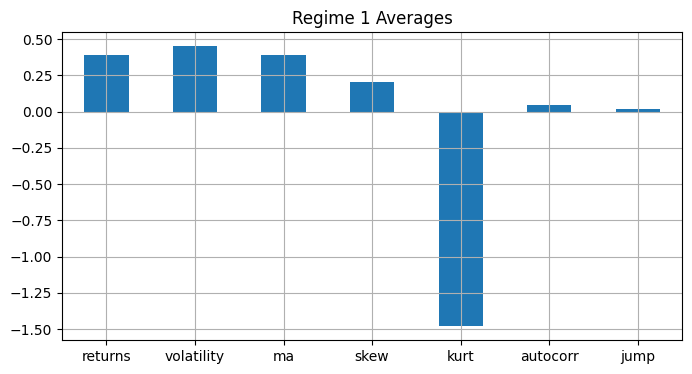

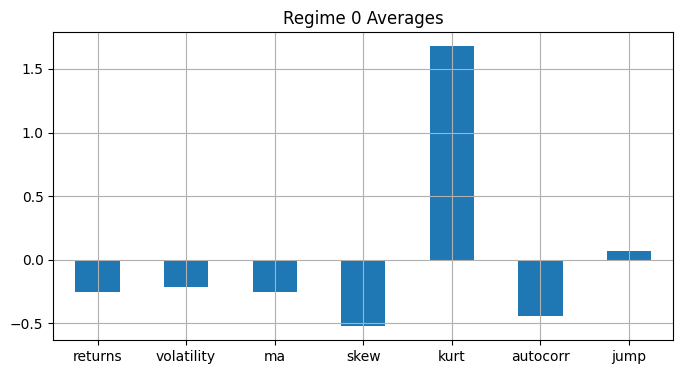

In [9]:
# PLOT REGIME AVERAGES TO DETERMINE REGIME NATURE.
# ==============================================================================================================

def plot_avgs(scaled_features, regime):
    plt.figure(figsize=(8,4))
    scaled_features[scaled_features['regime'] == regime].drop(columns='regime').mean().plot(kind='bar')
    plt.title(f'Regime {regime} Averages')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.show()
# --------------------------------------------------------------------------------------------------------------

plot_avgs(scaled_features, regime=1)
plot_avgs(scaled_features, regime=0)

Based on our visualizations, we find that each regime is characterized as such:

#### Regime 1

- **Higher returns:** This could suggest a more bullish paradigm.
- **Higher volatility:** The market might be riskier or more uncertain, but also potentially providing more opportunities for gains.
- **Positive skew:** This suggests the presence of larger upward movements.
- **Negative kurtosis:** This indicates fewer extreme outliers or less 'fat tails', suggesting that price movements are more likely to follow a normal distribution.

#### Regime 0

- **Negative returns:** This could suggest a bearish paradigm.
- **Lower volatility:** The market might be less risky but also providing fewer opportunities for large gains.
- **Negative skew:** This suggests the presence of larger downward movements.
- **Positive kurtosis:** This indicates more extreme outliers or 'fatter tails', suggesting that large price movements (in either direction) are more likely.

Given these characteristics, I'll deem Regime 1 more suitable for long positions: the higher returns and positive skew indicate bullish trends that could be profitable when betting on a rise in prices. Regime 2 will be for short positions: the negative returns and negative skew suggest profits could be made from betting on the decline.

### 3. Building the Strategy

#### Introducing `momentum` and `regime_stability_period`

In our regime-based trading algorithm, we're introducing two critical parameters: `momentum` and `regime_stability_period`. These measures provide us with a more nuanced understanding of the market conditions and enhance the effectiveness of our trading decisions.

`momentum` in our trading strategy is calculated as the percentage change over the `regime_stability_period`. This choice is made to ensure that our momentum calculation aligns with our assessment of regime stability, offering an integrated perspective of market dynamics. Aligning the two in such a way helps us capture the trending behavior of the market that is consistent with the duration of regime stability. If the market regime has remained stable for a specific period (as dictated by `regime_stability_period`), we want to understand the directional movement (upward or downward) of the market prices during that same period. 

To illustrate, a positive value for `momentum = prices.pct_change(5)`, where `5` is the `regime_stability_period`, means that not only has the market regime been stable (unchanged) for the last five periods, but also that the market prices have been consistently rising during these periods. The main thing that this alignment helps us with is the confirmation of the persistence of a market regime, as well as the corresponding directional trend of prices.

Note that I use momentum as an indicator mainly for position exits. This is because it reflects the speed and direction of price changes, which can be an early warning of a possible regime shift or change in the trend. For instance, a sharp decline in momentum during a bullish regime could suggest a potential switch to a bearish market, prompting us to exit a long position. This use of momentum allows us to capitalize on market movements in a timely manner.

In [10]:
# DECLARE REGIME STABILITY PERIOD AND ADD MOMENTUM TO UNSEEN_DATA.
# ======================================================================================================================

regime_stability_period = 10
unseen_data['momentum'] = unseen_data['prices'].pct_change(regime_stability_period)
display(unseen_data[10:].head(2))

,prices,returns,volatility,ma,skew,kurt,autocorr,jump,regime,momentum
Date,,,,,,,,,,
2020-02-14,337.60,0.001601,0.008429,0.000999,-0.782403,0.778419,-0.133879,0,0,0.049327
2020-02-18,336.73,-0.002580,0.008450,0.000715,-0.669692,0.616905,-0.126597,0,0,0.038905


### The Strategy

Our trading strategy hinges on a two-part framework: identification of market regimes and generation of trading signals, supported by momentum. This procedure cycles through the `unseen_data` dataset from an index defined by the `regime_stability_period` to its penultimate row.

During each iteration, the strategy:

1. Identifies the market regime (1 for long trades, 0 for short trades).
2. Checks the regime's stability over a certain period (regime_stability_period).
3. Evaluates the momentum over the same period against a threshold.
4. Generates trading signals based on the regime, its stability, and the momentum.
5. Logs the trades triggered by these signals.

In practice, the strategy goes long if a stable bullish regime is identified and no position is currently open. Conversely, it goes short under a stable bearish regime without an open position.

Positions are exited based on the changes in the regime or if the momentum exceeds (for long positions) or falls below (for short positions) a certain threshold. This way, the strategy dynamically adapts to regime shifts and rapid changes in market momentum, enhancing its responsiveness to market fluctuations.

In [15]:
# DEFINE TRADING BACKTEST FUNCTION.
# ======================================================================================================================

def trade_by_regime(unseen_data, allocation, momentum_threshold=0.1, fees=0.002, taxes=0.15, regime_stability_period=5):

    in_position, position, current_trade = False, None, {}
    trades = clustering.initialize_trade_log()

    for i in range(regime_stability_period - 1, len(unseen_data) - 1):

        current_regime = unseen_data.regime[i]
        past_regimes = unseen_data.regime[i-regime_stability_period:i]
        is_stable_regime = (past_regimes == current_regime).all()

        # long entries and exits
        long_signal = is_stable_regime and current_regime == 1
        exit_long = position == 'long' and (current_regime == 0 or unseen_data.momentum[i] < -momentum_threshold)

        # short entries and exits
        short_signal = is_stable_regime and current_regime == 0
        exit_short = position == 'short' and (current_regime == 1 or unseen_data.momentum[i] > momentum_threshold)

        if not in_position and long_signal:
            position = 'long'
            current_trade, in_position = clustering.log_entry(current_trade, in_position, position, unseen_data, i)
        
        elif not in_position and short_signal:
            position = 'short'
            current_trade, in_position = clustering.log_entry(current_trade, in_position, position, unseen_data, i)

        if in_position and exit_long:
            current_trade, in_position = clustering.log_exit(current_trade, in_position, unseen_data, i)
            trades = pd.concat([trades, pd.DataFrame([current_trade])], ignore_index=True)
            position, current_trade = None, {}
            
        elif in_position and exit_short:
            current_trade, in_position = clustering.log_exit(current_trade, in_position, unseen_data, i)
            trades = pd.concat([trades, pd.DataFrame([current_trade])], ignore_index=True)
            position, current_trade = None, {}

    prev_end_balance = allocation
    for i in range(len(trades)):
        trades = clustering.compute_stats(i, trades, unseen_data, prev_end_balance, fees)
        if trades.loc[i, 'profit'] > 0:
            tax = trades.loc[i, 'profit'] * taxes
        else:
            tax = 0
        trades.loc[i, 'taxes'] = tax
        trades.loc[i, 'end_balance'] -= tax
        prev_end_balance = trades.loc[i, 'end_balance']
        
    trades.drop(columns=['entry_fee', 'exit_fee'], inplace=True)
    trades.index.name = 'trade'
    trades.index += 1
    return trades
# ----------------------------------------------------------------------------------------------------------------------

allocation = 5000
momentum_threshold = 0.075
fees_pct = 0.002
tax_pct = 0.15
regime_stability_period = 5

trades = trade_by_regime(unseen_data, allocation, momentum_threshold, fees_pct, tax_pct, regime_stability_period)

In [16]:
display(trades.head())
display(trades.tail())

,position,entry,exit,entry_price,exit_price,shares,fees,taxes,profit,start_balance,end_balance,returns,vol
trade,,,,,,,,,,,,,
1,short,2020-02-07,2020-02-24,332.20,322.42,15.021072,19.686188,20.582984,137.219893,5000,5116.636909,0.027444,0.011446
2,short,2020-03-03,2020-03-18,300.24,240.00,17.007739,18.396989,152.457375,1016.382498,5116.636909,5980.562032,0.198643,0.06468
3,long,2020-03-25,2020-03-26,246.79,261.20,24.184938,24.595336,50.380612,335.870748,5980.562032,6266.052168,0.05616,0.02962
4,long,2020-03-27,2020-04-13,253.42,275.66,24.676506,26.136755,80.280125,535.200835,6266.052168,6720.972878,0.085413,0.032217
5,long,2020-04-22,2020-04-29,279.10,293.21,24.032716,27.535211,48.751253,325.008352,6720.972878,6997.229977,0.048357,0.012007


,position,entry,exit,entry_price,exit_price,shares,fees,taxes,profit,start_balance,end_balance,returns,vol
trade,,,,,,,,,,,,,
42,long,2022-10-21,2022-11-11,374.29,398.51,15.800619,24.44514,55.514636,370.097574,5925.86528,6240.448218,0.062455,0.019461
43,short,2022-11-18,2022-11-25,396.03,402.33,15.725999,25.134979,0,-111.727875,6240.448218,6128.720344,-0.017904,0.006509
44,short,2022-11-28,2022-12-30,395.91,382.43,15.449125,24.073858,29.465667,196.437782,6128.720344,6295.692458,0.032052,0.013183
45,long,2023-01-09,2023-04-14,387.86,412.46,16.199405,25.954598,57.771321,385.142141,6295.692458,6623.063277,0.061176,0.009957
46,short,2023-05-02,2023-05-19,410.84,418.62,16.088543,26.716099,0,-138.638839,6623.063277,6484.424438,-0.020933,0.008323


Overall, our strategy seems profitable. But the value of a strategy to an investor lies not only in its profitability, but also its risk profile weighed against its profitability, and other such measures. It also matters if the strategy is more profitable (and by how much more) than a simpler benchmark, such as simply buying and holding for the same period. If a simpler strategy yields marginally smaller profits, it may not be worth incurring fees or assumign the risk inherent to our algorithm.

To get a better idea of our backtest, we can compute metrics like its Sharpe Ratio, Maximum Drawdown, and the like.

In [17]:
# COMPUTE TRADE METRICS
# ======================================================================================================================

def total_profit(trades):
    profit = trades.end_balance.iloc[-1] - trades.start_balance.iloc[0]
    return profit

def total_return(trades):
    tot_ret = total_profit(trades) / trades.start_balance.iloc[0]
    return tot_ret

def sharpe_ratio(trades):
    annualized_mean_return = trades.returns.mean() * 252
    annualized_mean_volatility = trades.returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_mean_return / annualized_mean_volatility
    return sharpe_ratio

def max_drawdown(trades):
    growth = (1 + trades.returns).cumprod() - 1
    running_max = growth.cummax()
    return (running_max - growth).max()

def alpha(trades):
    benchmark_ret = trades.exit_price.iloc[-1] / trades.entry_price.iloc[0] - 1
    algo_ret =  total_return(trades)
    alpha = algo_ret - benchmark_ret
    return alpha, benchmark_ret

def summarize_backtest(trades):
    tot_ret, sharpe, max_dd, (alph, bm_ret) = total_return(trades), sharpe_ratio(trades), max_drawdown(trades), alpha(trades)
    print("{:<35} {:>15,.3f}".format('Total return of Trading Algorithm:', tot_ret))
    print("{:<35} {:>15,.3f}".format('Return from buying-holding SPY:', bm_ret))
    print("{:<35} {:>15,.3f}".format('Sharpe Ratio of Trading Algorithm:', sharpe))
    print("{:<35} {:>15,.3f}".format('Max Drawdown of Trading Algorithm:', max_dd))
    print("{:<35} {:>15,.3f}".format('Alpha of Trading Algorithm:', alph))
# ----------------------------------------------------------------------------------------------------------------------

summarize_backtest(trades)

Total return of Trading Algorithm:            0.297
Return from buying-holding SPY:               0.260
Sharpe Ratio of Trading Algorithm:            3.237
Max Drawdown of Trading Algorithm:            0.480
Alpha of Trading Algorithm:                   0.037


Our algorithm seemed to have outperformed a simple buy-and-hold strategy on the S&P 500 (SPY) over the same period, having delivered a total return of 29.7% compared to 26% from the SPY. The Sharpe ratio of the algorithm, at 3.237, suggests a better risk-adjusted performance, as it indicates the algorithm generated higher returns for each unit of risk taken. However, the algorithm has experienced a significant maximum drawdown of 48.0%, which is a concern as it indicates a substantial decline from a peak. Additionally, the alpha of the algorithm is positive at 0.037, indicating that the algorithm is generating excess returns over what would be predicted by its risk level, as measured by beta. In conclusion, while the algorithm is producing higher total returns and risk-adjusted performance than buying and holding the SPY, it also carries a significant risk in the form of its maximum drawdown. 

To close off this paper, let's plot the equity curve of our algorithm.

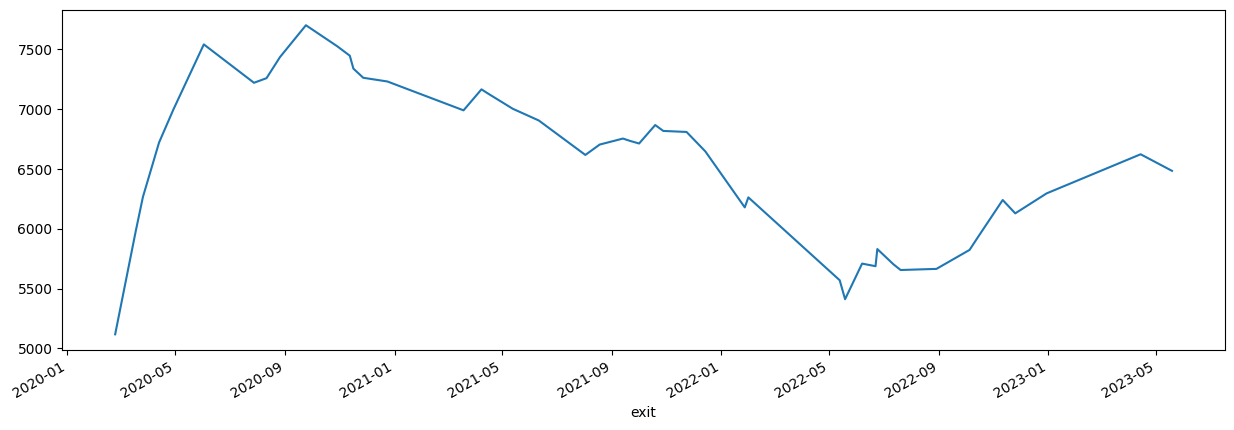

In [14]:
plt.figure(figsize=(15,5))
trades.end_balance.index = trades.exit
trades.end_balance.plot();